In [2]:
# Importing tensorflow

import tensorflow as tf

In [3]:
tf.__version__

'2.5.0'

In [4]:
!pip install tensorflow-gpu

In [5]:
# Checking for GPU info

!nvidia-smi

Sun Jun  6 14:30:42 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Importing required libraries

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Dropout,BatchNormalization,GlobalAveragePooling2D
import numpy as np
from tensorflow.keras.applications import Xception
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import matplotlib.pyplot as plt

## Assign the train and testing data paths and check for label counts

In [7]:
image_size = [224, 224, 3] # fixing the image size
train_path = '/content/drive/MyDrive/brain_mri_data/Training'
valid_path = '/content/drive/MyDrive/brain_mri_data/Testing'

In [8]:
print("Training Data labels and the number of images in it:")
print()
for i in os.listdir(train_path):
    print("Label:",i,"\n","# of Images:",len(os.listdir(train_path+"/"+i)))
    print()

Training Data labels and the number of images in it:

Label: meningioma_tumor 
 # of Images: 822

Label: glioma_tumor 
 # of Images: 826

Label: no_tumor 
 # of Images: 395

Label: pituitary_tumor 
 # of Images: 827



In [9]:
print("Testing Data labels and the number of images in it:")
print()
for i in os.listdir(valid_path):
    print("Label:",i,"\n","# of Images:",len(os.listdir(valid_path+"/"+i)))
    print()

Testing Data labels and the number of images in it:

Label: pituitary_tumor 
 # of Images: 74

Label: glioma_tumor 
 # of Images: 100

Label: meningioma_tumor 
 # of Images: 115

Label: no_tumor 
 # of Images: 105



# Visualize random 5 images from each label

In [10]:
def viz_label(name):
  plt.figure(figsize=(15,15))
  print("Random 5 images of ",name)
  for m in range(5):    
      plt.subplot(1,5,m+1)
      image_folder = train_path+'/'+name
      random_image = np.random.choice(os.listdir(image_folder))
      image_ = plt.imshow(plt.imread(image_folder+"/"+random_image))
  plt.show()

Random 5 images of  pituitary_tumor


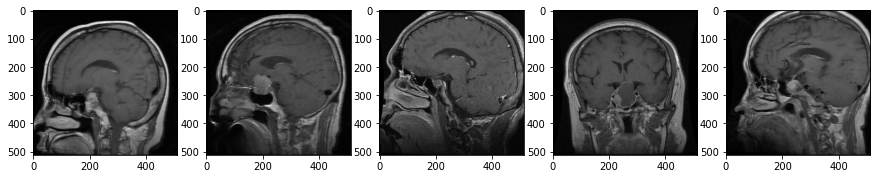

In [11]:
viz_label("pituitary_tumor")

Random 5 images of  glioma_tumor


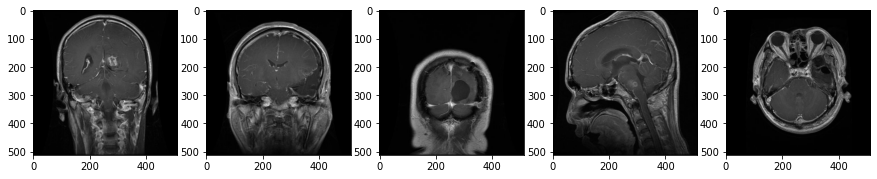

In [12]:
viz_label("glioma_tumor")

Random 5 images of  meningioma_tumor


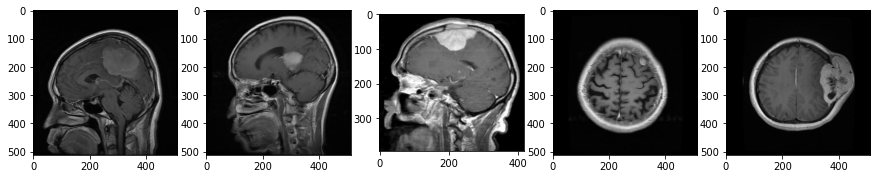

In [13]:
viz_label("meningioma_tumor")

Random 5 images of  no_tumor


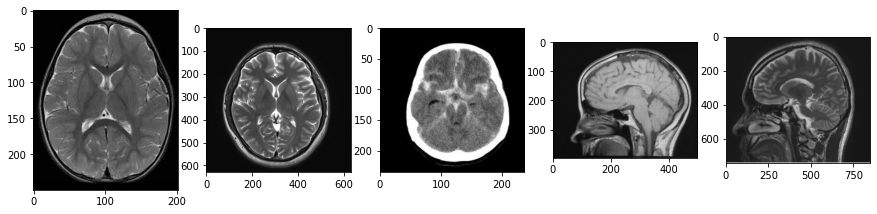

In [14]:
viz_label("no_tumor")

# Importing the training and the testing dataset using Imagedatagenerator

In [15]:
# Augment the training images with normalization to get different versions of images.
# Only rescale the test dataset
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [16]:
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(valid_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 2870 images belonging to 4 classes.
Found 394 images belonging to 4 classes.


# Instantiate Xception

In [18]:
# Instantiating Xception Trained model with include_top=False to exclude the top Dense layers in xnet variable.

xnet=Xception(input_shape=image_size,include_top=False)

83689472/83683744 [==============================] - 1s 0us/step


In [19]:
xnet.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [20]:
# Freeze the lower convolution layers of the xnet

xnet.trainable=False
xnet.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [21]:
# Successfully froze the convolution layers.

In [23]:
# Take the weights from pre-trained for xnet model frozen conv2D layers
# Train the dense models where back propagation optimization happens.

transfer_xnet=Sequential([xnet,
                          GlobalAveragePooling2D(),
                          Dense(512,activation="relu"),
                          Dense(4,activation="softmax")
                          ])

transfer_xnet.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 7, 7, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 2052      
Total params: 21,912,620
Trainable params: 1,051,140
Non-trainable params: 20,861,480
_________________________________________________________________


In [24]:
# Complile

transfer_xnet.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])

In [25]:
# Fit the model

hist=transfer_xnet.fit(training_set,
                  steps_per_epoch=2870//32,
                  epochs=10,
                  validation_data=test_set,
                  validation_steps=394//32)

Epoch 1/10
89/89 [==============================] - 1008s 11s/step - loss: 0.6465 - accuracy: 0.7463 - val_loss: 1.3319 - val_accuracy: 0.6120
Epoch 2/10
89/89 [==============================] - 363s 4s/step - loss: 0.4302 - accuracy: 0.8407 - val_loss: 1.3373 - val_accuracy: 0.6354
Epoch 3/10
89/89 [==============================] - 357s 4s/step - loss: 0.4028 - accuracy: 0.8492 - val_loss: 0.9609 - val_accuracy: 0.7188
Epoch 4/10
89/89 [==============================] - 367s 4s/step - loss: 0.3405 - accuracy: 0.8717 - val_loss: 1.2201 - val_accuracy: 0.7031
Epoch 5/10
89/89 [==============================] - 356s 4s/step - loss: 0.3232 - accuracy: 0.8753 - val_loss: 1.1792 - val_accuracy: 0.7005
Epoch 6/10
89/89 [==============================] - 349s 4s/step - loss: 0.3201 - accuracy: 0.8721 - val_loss: 1.1865 - val_accuracy: 0.6719
Epoch 7/10
89/89 [==============================] - 357s 4s/step - loss: 0.2924 - accuracy: 0.8830 - val_loss: 1.1142 - val_accuracy: 0.7161
Epoch 8/10


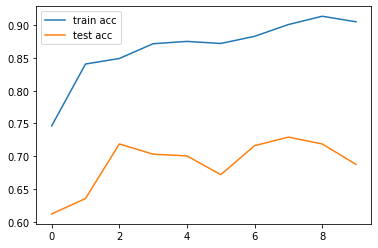

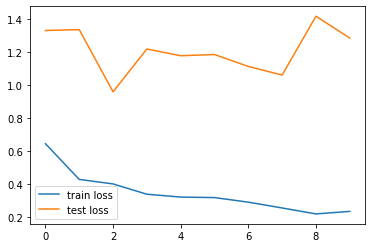

In [26]:
plt.plot(hist.history["accuracy"],label="train acc")
plt.plot(hist.history["val_accuracy"],label="test acc")
plt.legend()
plt.show()

plt.plot(hist.history["loss"],label="train loss")
plt.plot(hist.history["val_loss"],label="test loss")
plt.legend()
plt.show()

In [27]:
# Model 2

In [29]:
transfer_xnet1=Sequential([xnet,
                          Flatten(),
                          Dropout(0.4),
                          Dense(128,activation="relu"),
                          Dense(4,activation="softmax")
                          ])

transfer_xnet1.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])


hist1=transfer_xnet1.fit(training_set,
                  steps_per_epoch=len(training_set),
                  epochs=10,
                  validation_data=test_set,
                  validation_steps=len(test_set))

Epoch 1/10
90/90 [==============================] - 374s 4s/step - loss: 2.6479 - accuracy: 0.7035 - val_loss: 2.0904 - val_accuracy: 0.5863
Epoch 2/10
90/90 [==============================] - 368s 4s/step - loss: 0.5609 - accuracy: 0.8369 - val_loss: 1.5392 - val_accuracy: 0.6726
Epoch 3/10
90/90 [==============================] - 369s 4s/step - loss: 0.5214 - accuracy: 0.8429 - val_loss: 1.9256 - val_accuracy: 0.6701
Epoch 4/10
90/90 [==============================] - 369s 4s/step - loss: 0.3224 - accuracy: 0.8909 - val_loss: 1.7925 - val_accuracy: 0.6066
Epoch 5/10
90/90 [==============================] - 368s 4s/step - loss: 0.2934 - accuracy: 0.8937 - val_loss: 1.2307 - val_accuracy: 0.6802
Epoch 6/10
90/90 [==============================] - 371s 4s/step - loss: 0.2454 - accuracy: 0.9122 - val_loss: 1.8972 - val_accuracy: 0.7259
Epoch 7/10
90/90 [==============================] - 368s 4s/step - loss: 0.2440 - accuracy: 0.9129 - val_loss: 1.5626 - val_accuracy: 0.7487
Epoch 8/10
90

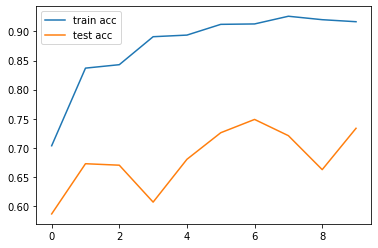

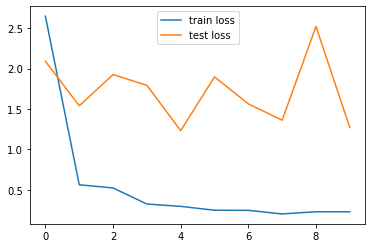

In [31]:
plt.plot(hist1.history["accuracy"],label="train acc")
plt.plot(hist1.history["val_accuracy"],label="test acc")
plt.legend()
plt.show()

plt.plot(hist1.history["loss"],label="train loss")
plt.plot(hist1.history["val_loss"],label="test loss")
plt.legend()
plt.show()

In [ ]:
# Conclusion:

# There is overfitting on the train data.

# Steps to handle overfitting:

# Introduce regularisation using lambda
# Vary the learning rate of the optimizer
# Add dropout/batchnormalization layer
# Do not use drop out and batch normalization both at once in one layer.
# use either of them.

# Other general options:

# Use call back.
# try different augmentaion options. It increases the generic behaviour.
# try different batch sizes.

# Due to high run time and computation resource constraint, I have stopped at this point.